# Model Assessment of Chris H's 4/26/2022

## Imports

In [58]:
%load_ext autoreload
%autoreload 2

import pickle
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from my_functions import plot_confusion_matrix, cost_scorer, savings_scorer, plotly_roc, create_cost_savings, plot_costs_by_threshold, plot_savings_by_threshold, quick_report

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First Run Through

In [2]:
bigg = pd.read_csv('./data/CJH_big_g_express_dataset_042622_817AM.csv', low_memory = False)

In [3]:
bigg['event_time_stamp'] = pd.to_datetime(bigg['event_time_stamp'])

bigg = bigg.loc[(bigg['event_time_stamp'].dt.year > 2014) & (bigg['event_time_stamp'].dt.year <= 2020)]

In [2]:
def create_groups(grp, df, offset_grp = None):
    df['full_derate'] = False
    
    if offset_grp is not None:
        df = df[df[f'use_for_first_tow_hours_id_group_{offset_grp}'] == False]
        
    df['full_derate'] = (
        np.where(df[f'hours_id_group_{grp}']\
                 .isin(list(df[f'hours_id_group_{grp}']\
                            .loc[(df[f'use_for_first_tow_hours_id_group_{grp}'] == True)])) &
                 (df[f'use_for_first_tow_hours_id_group_{grp}'] == True),
                 True,
                 False)
        )
    
    
    mask = df.loc[(df[f'hours_id_group_{grp}']\
                    .isin(list(df[f'hours_id_group_{grp}']\
                               .loc[(df[f'use_for_first_tow_hours_id_group_{grp}'] == True)]))) &
                    (df['full_derate'] == False)]
    
    row_ls = [i for i in df.index if i not in mask.index]
    
    df = df.loc[row_ls]
    
    grp_col = f'hours_id_group_{grp}'
    
    return df, grp_col

In [5]:
bigg_train, grp_col_train = create_groups('5D', bigg)

In [6]:
bigg_test, grp_col_test = create_groups('5D', bigg, '1H')

C:\Users\charr\AppData\Local\Temp\ipykernel_6080\536085104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_derate'] = (


In [3]:
def create_X_and_y_from_bigg(df, grp_col, training = False):    
    df['common_derate_lamp_status'] = (
        np.where((df['lamp_status'] == 22527) | (df['lamp_status'] == 18431), True, False)
    )

    df['fuel_temperature_over_32'] = (
        np.where(df['fuel_temperature'] > 32, True, False)
    )

    df['accelerator_pedal_over_0'] = (
        np.where(df['accelerator_pedal'] > 0, True, False)
    )

    df['cruise_control_set_speed_under_66'] = (
        np.where(df['cruise_control_set_speed'] < 66, True, False)
    )

    df['switched_battery_voltage_less_than_3276.75'] = (
        np.where(df['switched_battery_voltage'] < 3276.75, True, False)

    )


    cat_var = [
        'common_derate_lamp_status',
        'ecu_model',
        'ecu_make',
        'error_category',
        'month',
        'fuel_temperature_over_32',
        'accelerator_pedal_over_0',
        'cruise_control_set_speed_under_66',
        'switched_battery_voltage_less_than_3276.75'
    ]

    normalizers = ['ltd_distance',
                 'ltd_engine_time',
                 'ltd_fuel']

    var = ['barometric_pressure',
           'ltd_distance',
           'engine_coolant_temperature',
           'engine_load',
           'engine_oil_pressure',
           'engine_oil_temperature',
           'engine_rpm',
           'ltd_engine_time',
           'fuel_level',
           'ltd_fuel',
           'fuel_rate',
           'intake_manifold_temperature',
           'speed',
           'turbo_boost_pressure',
           'error_duration_(minutes)'
          ]


    ohe_col_ls = []
    for i in cat_var:
        ohe = OneHotEncoder()
        transformed = ohe.fit_transform(df[[i]])
        df[ohe.get_feature_names_out()] = transformed.toarray()
        ohe_col_ls += [i for i in ohe.get_feature_names_out()]

    def log_me(col):
        df[col] = (
            np.where((df[col].notnull()) & 
                     (np.log(df[col]) != -np.inf) &
                     (np.log(df[col]) != np.inf), 
                     np.log(df[col]), np.nan)
        )

        return df[col]

    log_cols = ['engine_oil_temperature',
                'ltd_engine_time',
                'fuel_rate',
                'turbo_boost_pressure',
                'speed',
                'error_duration_(minutes)']

    df['barometric_pressure'] = np.exp(df['barometric_pressure'])

    for i in log_cols:
        df[i] = log_me(i)

    cat_vars = df.groupby(grp_col)[ohe_col_ls].sum().reset_index()

    mean_vars = df.groupby(grp_col)[var].mean().reset_index().fillna(0)
    std_vars = df.groupby(grp_col)[var].std().reset_index().fillna(0)

    target_values = df[[grp_col, 'full_derate']].drop_duplicates()

    all_vars = pd.merge(mean_vars, std_vars, on = grp_col).merge(cat_vars, on = grp_col)
    
    if training == True:
        all_groups = pd.merge(all_vars, target_values, on = grp_col)
        all_groups_true = all_groups.loc[all_groups['full_derate'] == True]
        all_groups_resampled_false = all_groups.loc[all_groups['full_derate'] == False].sample(frac = 0.8)
        all_groups = pd.concat([all_groups_true, all_groups_resampled_false])
        X = all_groups.drop(columns = [grp_col,'full_derate'])
        y = all_groups['full_derate']
    else:
        X = all_vars.drop(columns = grp_col)
        y = target_values['full_derate']

    return X, y

In [8]:
train_X, train_y = create_X_and_y_from_bigg(bigg_train, grp_col_train, training = True)
test_X, test_y = create_X_and_y_from_bigg(bigg_test, grp_col_test, training = False)

C:\Users\charr\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\charr\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\charr\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\charr\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
X_train, _, y_train, _ = train_test_split(train_X, train_y,
                                       test_size = 0.30, 
                                       train_size = 0.70, 
                                       random_state = 111,
                                       stratify = train_y)

_, X_test, _, y_test = train_test_split(test_X, test_y, 
                                      test_size = 0.30, 
                                      train_size = 0.70, 
                                      random_state = 111, 
                                      stratify = test_y)

In [10]:
pipe = Pipeline(
    steps = [
        ('smt', SMOTE(n_jobs = -1)),
        ('scale', StandardScaler()),
        ('boost', XGBClassifier(verbosity = 2, n_jobs = -1))
    ]
)

In [11]:
cv = cross_val_score(estimator = pipe,
                     X = X_train,
                     y = y_train, 
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'f1', 
                     verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   53.8s remaining:   35.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.3s finished


In [12]:
cv

array([0.58823529, 0.58333333, 0.54961832, 0.49180328, 0.57971014])

In [13]:
pipe.fit(X_train, y_train)

C:\Users\charr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:44:15] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[08:44:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:15] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[08:44:16] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[08:44:16] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[08:44:16] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[08:44:16] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[08:44:16] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 8

[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[08:44:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[08:44:27] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

Pipeline(steps=[('smt', SMOTE(n_jobs=-1)), ('scale', StandardScaler()),
                ('boost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               ve

In [14]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22039
        True       0.58      0.44      0.50       103

    accuracy                           1.00     22142
   macro avg       0.79      0.72      0.75     22142
weighted avg       1.00      1.00      1.00     22142



In [15]:
print(confusion_matrix(y_test, pipe.predict(X_test)))

[[22006    33]
 [   58    45]]


In [16]:
importances = pd.DataFrame({
    'variable': X_train.columns,
    'importance': pipe['boost'].feature_importances_
})

importances.sort_values('importance', ascending = False).head(10)

,variable,importance
68,error_category_SCR-Related,0.405179
88,switched_battery_voltage_less_than_3276.75_True,0.155620
31,common_derate_lamp_status_True,0.061178
7,ltd_engine_time_x,0.040818
6,engine_rpm_x,0.027323
78,month_November,0.017709
82,fuel_temperature_over_32_True,0.017597
65,ecu_make_Unknown,0.016212
61,ecu_make_BNDWS,0.014563
16,ltd_distance_y,0.014247


In [17]:
import pickle

with open('./data/boost_42622.pkl', 'wb') as file:
    pickle.dump(pipe, file = file)

## Model Assessment

In [9]:
with open('../data/boost_42622.pkl', 'rb') as file:
    pipe = pickle.load(file)

In [10]:
bigg = pd.read_csv('../data/CJH_big_G_042622.csv', low_memory = False)

### Test Model on Different Offsets (Windows)

In [11]:
offsets = [None, '15min', '30min', '45min', '1H', '2H', '3H', '6H', '8H', '11H', '14H']

selected_thresholds = []
test_savings = []
windows_dict = {'costs': {'train': dict(), 'test': dict()}, 
                'savings': {'train': dict(), 'test': dict()}}
probs_dict = {'train': dict(), 'test': dict()}
true_dict = {'train': dict(), 'test': dict()}

for offset in tqdm(offsets):

    bigg['event_time_stamp'] = pd.to_datetime(bigg['event_time_stamp'])

    bigg = bigg.loc[(bigg['event_time_stamp'].dt.year > 2014) & (bigg['event_time_stamp'].dt.year <= 2020)]

    bigg_train, grp_col_train = create_groups('5D', bigg)

    bigg_test, grp_col_test = create_groups('5D', bigg, offset)

    train_X, train_y = create_X_and_y_from_bigg(bigg_train, grp_col_train, training = True)
    test_X, test_y = create_X_and_y_from_bigg(bigg_test, grp_col_test, training = False)

    X_train, _, y_train, _ = train_test_split(train_X, train_y,
                                        test_size = 0.30, 
                                        train_size = 0.70, 
                                        random_state = 111,
                                        stratify = train_y)

    _, X_test, _, y_test = train_test_split(test_X, test_y, 
                                        test_size = 0.30, 
                                        train_size = 0.70, 
                                        random_state = 111, 
                                        stratify = test_y)

    y_train_prob = pipe.predict_proba(X_train)
    y_test_prob = pipe.predict_proba(X_test)

    train_savings_df = create_cost_savings(y_train, y_train_prob, type = 'savings')
    test_savings_df = create_cost_savings(y_test, y_test_prob, type = 'savings')

    train_cost_df = create_cost_savings(y_train, y_train_prob, type = 'costs')
    test_cost_df = create_cost_savings(y_test, y_test_prob, type = 'costs')

    train_cost_df['threshold'] = train_cost_df['threshold'].round(4)
    test_cost_df['threshold'] = test_cost_df['threshold'].round(4)
    train_cost_df['percent_of_savings'] = 100*train_cost_df['total_costs']/train_cost_df.loc[train_cost_df['threshold'] == 1, 'total_costs'].values
    test_cost_df['percent_of_savings'] = 100*test_cost_df['total_costs']/test_cost_df.loc[test_cost_df['threshold'] == 1, 'total_costs'].values

    best_thresh = train_savings_df.nlargest(1, 'total_savings')['threshold'].values[0]
    selected_thresholds.append(best_thresh)
    test_savings.append(test_savings_df.loc[test_savings_df['threshold'] == best_thresh, 'total_savings'].values[0])

    true_dict['train'][offset] = y_train
    true_dict['test'][offset] = y_test

    probs_dict['train'][offset] = y_train_prob
    probs_dict['test'][offset] = y_test_prob

    windows_dict['costs']['train'][offset] = train_cost_df
    windows_dict['costs']['test'][offset] = test_cost_df
    windows_dict['savings']['train'][offset] = train_savings_df
    windows_dict['savings']['test'][offset] = test_savings_df    

  0%|          | 0/11 [00:00<?, ?it/s]C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarni

### Pickle for Later Use

In [16]:
with open('../data/refined_xgboost_assessment/windows_dict.pickle', 'wb') as file:
    pickle.dump(windows_dict, file, protocol=-1)

with open('../data/refined_xgboost_assessment/probs_dict.pickle', 'wb') as file:
    pickle.dump(probs_dict, file, protocol=-1)

with open('../data/refined_xgboost_assessment/true_dict.pickle', 'wb') as file:
    pickle.dump(true_dict, file, protocol=-1)

with open('../data/refined_xgboost_assessment/selected_thresholds_list.pickle', 'wb') as file:
    pickle.dump(selected_thresholds, file, protocol=-1)

with open('../data/refined_xgboost_assessment/test_savings_list.pickle', 'wb') as file:
    pickle.dump(test_savings, file, protocol=-1)

### Check Optimum Threshold by Window
Surprisingly, these are 0.5 in each case.

In [68]:
dict(zip(offsets,selected_thresholds))

{None: 0.5,
 '15min': 0.5,
 '30min': 0.5,
 '45min': 0.5,
 '1H': 0.5,
 '2H': 0.5,
 '3H': 0.5,
 '6H': 0.5,
 '8H': 0.5,
 '11H': 0.5,
 '14H': 0.5}

### Graph Model Performance by Offset (Window)
- Our model performs very well in urgent situations (less than 15 minutes)
- The best window by savings and time is 2 hours.
- Still catches some derates very early (11 hours and 14 hours).

In [13]:
offsets_readable = ['0min']+offsets[1:]
windows_df = pd.DataFrame({
        'window': offsets_readable,
        'test_savings': test_savings,
        'precision': [windows_dict['savings']['test'][x].nlargest(1, 'total_savings')['precision'].values[0] for x in offsets],
        'recall': [windows_dict['savings']['test'][x].nlargest(1, 'total_savings')['recall'].values[0] for x in offsets],
        'percent_of_actual_costs': [windows_dict['costs']['test'][x].nsmallest(1, 'total_costs')['percent_of_savings'].values[0] for x in offsets]
})

windows_df

,window,test_savings,precision,recall,percent_of_actual_costs
0,0min,565000.0,0.557018,0.907143,16.500000
1,15min,233000.0,0.415205,0.657407,43.518519
2,30min,211000.0,0.362573,0.584906,51.792453
3,45min,191500.0,0.361290,0.528302,56.509434
4,1H,208500.0,0.328431,0.650485,48.252427
5,2H,225000.0,0.326425,0.636364,49.494949
6,3H,179000.0,0.292553,0.578947,56.105263
7,6H,129500.0,0.267442,0.528736,61.609195
8,8H,147500.0,0.432099,0.421687,63.373494
9,11H,125500.0,0.260606,0.551282,60.512821


In [47]:
fig_windows = px.line(x = windows_df['window'],
        y = windows_df['test_savings'],
        hover_data=[windows_df['precision'].round(2), windows_df['recall'].round(2), windows_df['percent_of_actual_costs'].round(2)],
        labels = {'x':'<b>Minimum Time from Derate<b>',
                  'y':'<b>Total Savings ($)<b>',
                  'hover_data_0':'Precision',
                  'hover_data_1':'Recall',
                  'hover_data_2':'Percent of Actual Costs'},
        title = "<b>Our XGBoost model performs well in urgent situations and 2+ hours out.<br>This model could have saved you 50% of your derate-related costs.<b>",
        width = 800,
        height = 500)
fig_windows['data'][0]['line']['color']='#F28D2E'
fig_windows

### ROC for Testing on at Least 2 Hours from Derate

In [59]:
fig_roc = plotly_roc(true_dict['test']['2H'], 
           probs_dict['test']['2H']
           )
fig_roc['data'][0]['line']['color']='#F28D2E'
fig_roc

The optimum tpr vs. fpr threshold value is: 7.3638024e-05


### Confusion Matrix for Testing on at Least 2 Hours from Derate

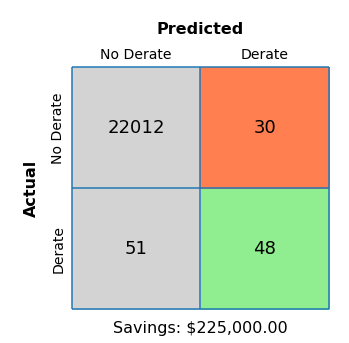

In [61]:
fig_cm = plot_confusion_matrix(true_dict['test']['2H'], [p[1] > 0.5 for p in probs_dict['test']['2H']], labels = ['No Derate', 'Derate'], metric = 'savings')
plt.savefig('../data/fig_refined_xgboost_cm.png')

## Send Figures for Presentation

In [62]:
import chart_studio
import json
import chart_studio.plotly as py
import chart_studio.tools as tls

username = 'jrioross'
api_key = json.load(open('../data/api_keys.json'))['chart_studio']

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [63]:
py.plot(fig_roc, filename = 'refined_xgboost_roc', auto_open=True)

'https://plotly.com/~jrioross/7/'

In [64]:
py.plot(fig_windows, filename = 'refined_xgboost_windows', auto_open=True)

'https://plotly.com/~jrioross/9/'

In [65]:
tls.get_embed('https://plotly.com/~jrioross/7/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~jrioross/7.embed" height="525" width="100%"></iframe>'

In [66]:
tls.get_embed('https://plotly.com/~jrioross/9/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~jrioross/9.embed" height="525" width="100%"></iframe>'